## Python Setup

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

Fetch the dataset from OpenML

In [4]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

## Preprocessing

Define the features we want to use, noting that 'survived' is the target and shouldn't be in features

In [7]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
X = X[features]

Add a 'FamilySize' feature

In [9]:
X['familysize'] = X['sibsp'] + X['parch'] + 1

Define numerical and categorical features

In [11]:
numerical_features = ['age', 'fare', 'familysize']
categorical_features = ['pclass', 'sex', 'embarked']

## Create preprocessing pipelines

In [13]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

## Combine preprocessing steps

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Create the RandomForestClassifier model pipeline

In [17]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

## Split the data
Note: y needs to be encoded to numerical before splitting if it's not already numerical

In [19]:
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Define a hyperparameter grid for cross validation

In [21]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 4]
}

## Create the GridSearchCV object

In [23]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', return_train_score=True)

## Train the model

In [25]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare',
                                                                          'familysize']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['pclass',
                                                                          'sex',
                                                                          'embarked'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 5, 10],
                         'classifier__min_samples_split': [2, 4],
                         'classifier__n_estimators': [100, 200]},
             return_train_score=True, scoring='roc_auc')

In [26]:
best_model = grid_search.best_estimator_

## Predict probabilities

In [28]:
probabilities = best_model.predict_proba(X_test)[:, 1]

## Calculate AUC

In [30]:
roc_auc = grid_search.best_score_

## Calculate ROC curve

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

## Plot ROC curve

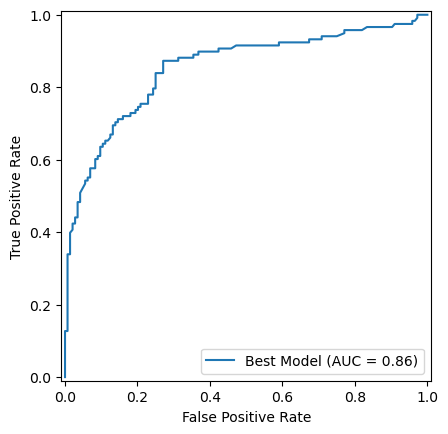

In [34]:
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Best Model').plot()
plt.show()